<a href="https://colab.research.google.com/github/madnanshinwari/DeepLearning-work/blob/main/Image_classification_using_Active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [ ]:
data_dir = '/content/drive/MyDrive/Active learning/car-bike'

categories = ['bike','car']

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 728 images belonging to 2 classes.
Found 94 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model on initial labeled data


In [ ]:
initial_train_size = int(0.2 * train_generator.samples )

train_data_intial = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training'
)


history = model.fit(
    train_generator,
    steps_per_epoch = initial_train_size // train_generator.batch_size,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = val_generator.samples // val_generator.batch_size
)

history_dict_initial = history.history

Found 728 images belonging to 2 classes.
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 786ms/step - accuracy: 0.4927 - loss: 0.9675 - val_accuracy: 0.4792 - val_loss: 0.7523
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - accuracy: 0.4510 - loss: 0.7249 - val_accuracy: 0.3684 - val_loss: 0.6911
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.5510 - loss: 0.6913 - val_accuracy: 0.4792 - val_loss: 0.6861
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.5167 - loss: 0.6850 - val_accuracy: 0.5789 - val_loss: 0.6664
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5104 - loss: 0.6963 - val_accuracy: 0.6458 - val_loss: 0.6786
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7282 - loss: 0.6722 - val_accuracy: 0.5789 - val_loss: 0.6370
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.5906 - loss: 0.6614 - val_accuracy: 0.5312 - val_loss: 0.6449
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step - accuracy: 0.6052 - loss: 0

### Use the Model to Make Predictions on Unlabeled Data

In [ ]:
# predict on the remaining unlabled data (80% of the training set)

unlabeled_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = None, # No labels since this is considered 'unlabled'
    shuffle = False
)

predictions = model.predict(unlabeled_data, steps = len(unlabeled_data), verbose = 1)


Found 728 images belonging to 2 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step


### select the most uncertain samples for labeling

In [ ]:
uncertainty = np.abs(predictions - 0.5) # measure uncertainty by calculating distance from 0.5 for binary classification

# select 20 % uncertain samples for labling
num_to_label = int(0.2 * len(uncertainty))
uncertain_indices = np.argsort(uncertainty)[:num_to_label]



# get the file names
uncertain_indices = np.ravel(uncertain_indices).tolist()
uncertain_files = [unlabeled_data.filenames[i] for i in uncertain_indices]

print(f'Most uncertain samples : {uncertain_files}')


Most uncertain samples : ['bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q__ (1).jpg', 'bike/2Q

### Retrain the model with labeled data

In [ ]:

# retrain the model with updated training set (including the labeled uncertain samples )
history = model.fit(
     train_generator,
     steps_per_epoch = train_generator.samples // train_generator.batch_size,
     epochs = 5,
     validation_data = val_generator,
     validation_steps = val_generator.samples // val_generator.batch_size
)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.8161 - loss: 0.4337 - val_accuracy: 0.8021 - val_loss: 0.4822
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8438 - loss: 0.3223 - val_accuracy: 0.8421 - val_loss: 0.2162
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.8784 - loss: 0.3179 - val_accuracy: 0.7292 - val_loss: 0.7375
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.3066 - val_accuracy: 0.7895 - val_loss: 1.0980
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.8468 - loss: 0.3546 - val_accuracy: 0.7917 - val_loss: 0.4485


### Evaluate the model on the Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps = test_generator.samples // test_generator.batch_size  )
print(f'Test accuracy : {test_acc * 100:.2f}% ')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.8646 - loss: 0.3826
Test accuracy : 84.38% 


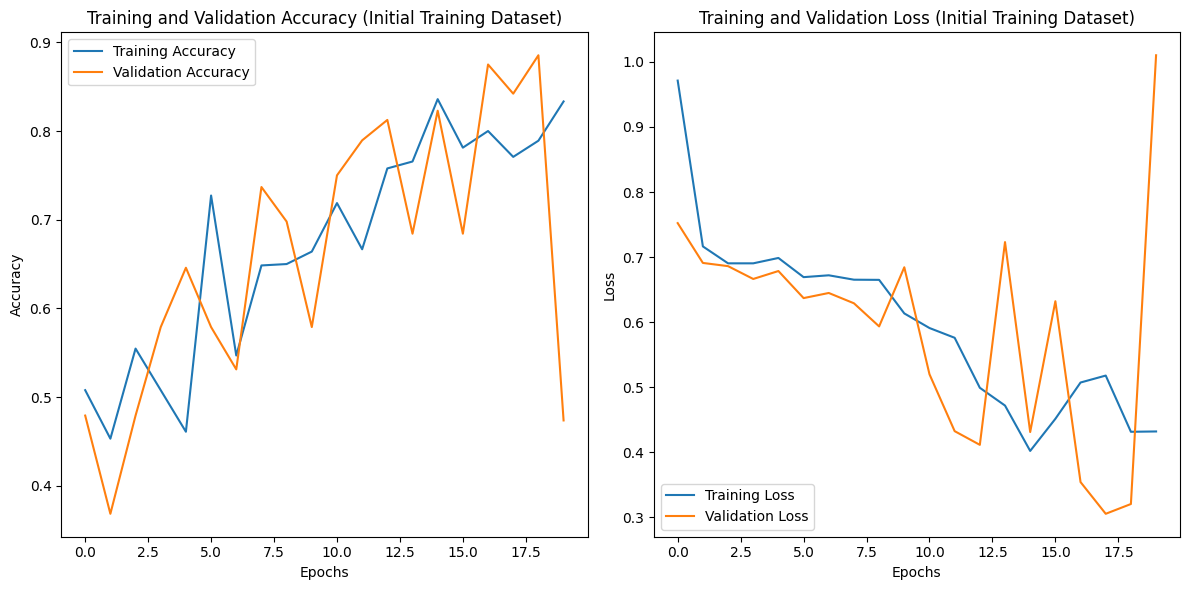

In [ ]:


# Plot training and validation accuracy for initial training
plt.figure(figsize=(12, 6))

# Plot for training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict_initial['accuracy'], label='Training Accuracy')
plt.plot(history_dict_initial['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Initial Training Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict_initial['loss'], label='Training Loss')
plt.plot(history_dict_initial['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Initial Training Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
